In [4]:
import torch
import numpy as np
import os
from skimage import io
from torchvision import transforms
from FishModel import FishModel


transform = transforms.Resize((256, 256))

model = FishModel(out_features=1024)
model.load_state_dict(torch.load('Models/best.pt', map_location=torch.device('cpu')))
model.to("cpu")

embeddings = []

for file in os.listdir("Images/References"):
    img = io.imread(os.path.join("Images/References", file))
    img = torch.from_numpy(img).permute(2,0,1) / 255.0
    img = transform(img).unsqueeze(0)

    # Get the embeddings
    emb = model(img)

    embeddings.append(emb.detach().numpy())

correct = 0
total = 0

actual_classes = [] 
predicted_classes = []

# For each file in the "Images/Test" folder, predict the class
for file in os.listdir("Images/Validationset"):
    img = io.imread(os.path.join("Images/Validationset", file))
    img = torch.from_numpy(img).permute(2,0,1) / 255.0
    img = transform(img).unsqueeze(0)

    # Get the embeddings
    emb = model(img)

    # Calculate the euclidean distance between the embeddings of the test image and the reference images
    distances = [np.linalg.norm(emb.detach().numpy() - e) for e in embeddings]

    # Get the index of the reference image with the smallest distance
    pred = np.argmin(distances)

    # Get the class of the reference image
    pred_class = pred + 1
    
    # Get the class of the test image
    actual_class = int(file.split("_")[0])

    # If the predicted class is the same as the actual class, increment the correct counter
    if pred_class == actual_class:
        correct += 1

    total += 1

    actual_classes.append(actual_class)
    predicted_classes.append(pred_class)

    # print(f"Predicted class: {pred +1 }, Distance: {distances}, File: {file}")

print(f"Accuracy: {correct/total * 100:.2f}%")

Accuracy: 86.65%


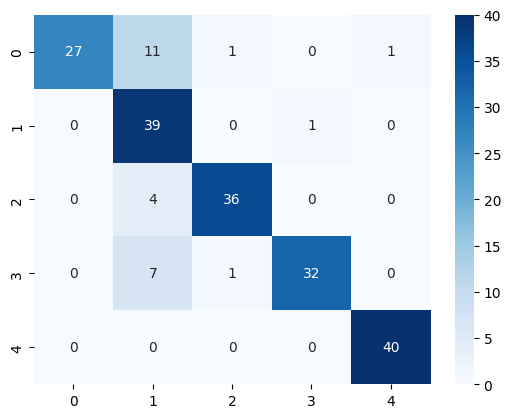

In [2]:
from sklearn.metrics import confusion_matrix
import seaborn

matrix = confusion_matrix(actual_classes, predicted_classes)

heatmap = seaborn.heatmap(matrix, annot=True, fmt='g', cmap='Blues')

figure = heatmap.get_figure()
#figure.savefig("cm_efficientnet_validationset.png", dpi=400)

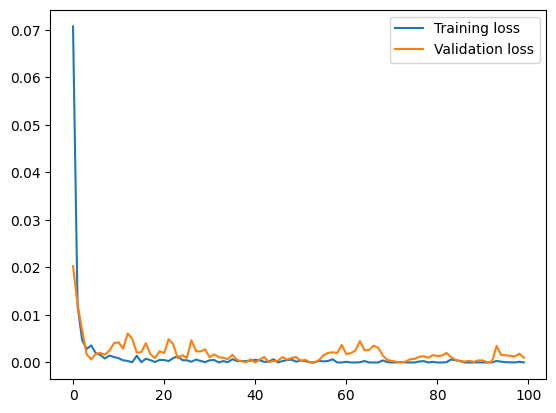

In [3]:
# Plot the training loss and validation loss stored in loss.txt on the format (training loss, validation loss)
import matplotlib.pyplot as plt

with open("loss.txt", "r") as f:
    lines = f.readlines()

lines = [line.split(",") for line in lines]

training_losses = [float(loss[0]) for loss in lines]
validation_losses = [float(loss[1]) for loss in lines]

plt.plot(training_losses, label="Training loss")

plt.plot(validation_losses, label="Validation loss")

plt.legend()

plt.savefig("loss_efficientnet.png", dpi=400)

plt.show()